# Comparison between initial Cox model and the GNN-Cox model
For details about initial Cox model and GNN-Cox model, see the associated notebooks (cox-model.ipynb and gnn-cox.ipynb).

## Table of contents

1. [Reading dataset, drop censored patients, and label patients](#0-reading-dataset-and-drop-censored-patients)
2. [Initial Cox model](#1-initial-cox-model)
3. [GNN-Cox model](#2-gnn-cox-model)
4. [Plot survival curves](#4-plot-survival-curves)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.BuildGraph import BuildGraph
from models.GCNClassifier import GCNClassifier
from manage.GCNTrainTestManager import GCNTrainTestManager
from models.CoxModel import CoxModel
from sklearn.model_selection import KFold 
from torch_geometric.utils import from_networkx

## 1. Reading dataset, drop censored patients, and label patients

### Reading dataset

In [2]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


### Delete censored patients

In [3]:
def drop_censored_patients(df: pd.DataFrame, status_name: str, time_name: str, t: float)->pd.DataFrame:
    """ 
    Delete censored patients from the initial dataframe. A censored patient is a patient with status = 0 and time_event < t.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe without censored patients.
    """

    # Get index of to drop patients
    to_drop = df.index[np.where((df[status_name] == 0) & (df[time_name]<t))[0]]
    print(f"{to_drop.shape[0]} patients censored deleted")

    # Update dataframe
    df_non_censored = df.drop(to_drop,axis=0)

    return df_non_censored

In [4]:
## TTP (Time To Progression)
t_ttp = np.median(df["Time to progression (days)"].to_numpy())
df_ttp_non_censored = drop_censored_patients(df, "Progression_1", "Time to progression (days)", t_ttp)

## OS (Overall survival)
t_os = np.median(df["Overall survival (days)"].to_numpy())
df_os_non_censored = drop_censored_patients(df, "Alive_0", "Overall survival (days)", t_os)

6 patients censored deleted
1 patients censored deleted


### Label patients for future classification

In [5]:
def label_patients(df: pd.DataFrame, time_name: str, t: float)->pd.DataFrame:
    """ 
    Create new column in dataframe with event label depending on status, time and t values.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe with an extra label column.
    """
    
    # We test if time < t (1 if yes, 0 otherwise)
    df["event_occured"] = np.where(df[time_name]<t, 1, 0)
    
    return df

In [6]:
## TTP :
df_ttp_non_censored = label_patients(df_ttp_non_censored, "Time to progression (days)",t_ttp)

## OS :
df_os_non_censored = label_patients(df_os_non_censored, "Overall survival (days)",t_os)

### Select features and label name

In [7]:
features_name = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]
label_name = "event_occured"

## 2. Initial Cox model

### Preprocessing data

In [8]:
## TTP :
X_init_ttp = df_ttp_non_censored.loc[:,features_name].to_numpy()
y_ttp = np.array(list((df_ttp_non_censored[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

## OS :
X_init_os = df_os_non_censored.loc[:,features_name].to_numpy()
y_os = np.array(list((df_os_non_censored[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

### Instanciate initial Cox model

In [9]:
## TTP :
cox_model_init_ttp = CoxModel()

## OS :
cox_model_init_os = CoxModel()

### Leave one out cross validation to train Cox Model and estimate risk class

In [10]:
## TTP : 
risk_classes_init_ttp, risk_scores_init_ttp = cox_model_init_ttp.leave_one_out_cross_validation(X_init_ttp,y_ttp)
print("TTP :")
print(f"n_samples high risk : {np.where(risk_classes_init_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_init_ttp==0)[0].shape[0]}")

## OS : 
print("\n OS :")
risk_classes_init_os, risk_scores_init_os = cox_model_init_os.leave_one_out_cross_validation(X_init_os,y_os)
print(f"n_samples high risk : {np.where(risk_classes_init_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_init_os==0)[0].shape[0]}")

TTP :
n_samples high risk : 42
n_samples low risk : 34

 OS :
n_samples high risk : 44
n_samples low risk : 37


### Estimate survival functions

In [11]:
## TTP :
status_init_ttp, time_init_ttp = df_ttp_non_censored['Progression_1'].to_numpy().astype(bool), df_ttp_non_censored['Time to progression (days)'].to_numpy()
# Low risk class
status_low_init_ttp, time_low_init_ttp = status_init_ttp[np.where(risk_classes_init_ttp==0)], time_init_ttp[np.where(risk_classes_init_ttp==0)]
time_axis_low_init_ttp, prob_axis_low_init_ttp = cox_model_init_ttp.kaplan_meier_estimation(status_low_init_ttp, time_low_init_ttp)
# High risk class
status_high_init_ttp, time_high_init_ttp = status_init_ttp[np.where(risk_classes_init_ttp==1)], time_init_ttp[np.where(risk_classes_init_ttp==1)]
time_axis_high_init_ttp, prob_axis_high_init_ttp = cox_model_init_ttp.kaplan_meier_estimation(status_high_init_ttp, time_high_init_ttp)

## OS :
status_init_os, time_init_os = df_os_non_censored['Alive_0'].to_numpy().astype(bool), df_os_non_censored['Overall survival (days)'].to_numpy()
# Low risk class
status_low_init_os, time_low_init_os = status_init_os[np.where(risk_classes_init_os==0)], time_init_os[np.where(risk_classes_init_os==0)]
time_axis_low_init_os, prob_axis_low_init_os = cox_model_init_os.kaplan_meier_estimation(status_low_init_os, time_low_init_os)
# High risk class
status_high_init_os, time_high_init_os = status_init_os[np.where(risk_classes_init_os==1)], time_init_os[np.where(risk_classes_init_os==1)]
time_axis_high_init_os, prob_axis_high_init_os = cox_model_init_os.kaplan_meier_estimation(status_high_init_os, time_high_init_os)

### Compute C index

In [12]:
## TTP : 
c_index_init_ttp = cox_model_init_ttp.get_c_index(status_init_ttp, time_init_ttp, risk_scores_init_ttp)
print(f"C index (TTP) : {c_index_init_ttp}")

## OS :
c_index_init_os = cox_model_init_os.get_c_index(status_init_os, time_init_os, risk_scores_init_os)
print(f"C index (OS) : {c_index_init_os}")

C index (TTP) : 0.58
C index (OS) : 0.55


### Compute log rank test p value

In [13]:
## TTP :
p_value_init_ttp = cox_model_init_ttp.log_rank_test(status_init_ttp.astype(int), time_init_ttp, risk_classes_init_ttp)
print(f"p value (TTP) : {p_value_init_ttp}")

## OS :
p_value_init_os = cox_model_init_os.log_rank_test(status_init_os.astype(int), time_init_os, risk_classes_init_os)
print(f"p value (OS) : {p_value_init_os}")

p value (TTP) : 0.02
p value (OS) : 0.11


## 3. GNN-Cox model

### Leave one out cross validation function

In [14]:
def leave_one_out_cross_validation(df: pd.DataFrame, column_name: str, features_name: list[str], label_name: str, n_epoch: int):
    """ 
    Make the leave one out cross validation to train-test GNN+Cox model pipeline.

    ### Parameters :
    - df : the dataframe.
    - column_name : the name of the column used to choose graph connections.
    - features_name : the name of the features for each patient
    - label_name : the name of the label for each patient
    - n_epoch : the number of epochs for GNN training.

    ### Returns :
    - the risk scores for each test patient
    - the risk classes for each test patient
    - the Cox Model trained (for the metrics later)
    """

    # Split dataframe in n_samples groups
    n_samples = df.shape[0]
    folds = KFold(n_splits=n_samples, shuffle=True).split(df)

    # Initialize list of test risk scores and classes for each patient
    risk_scores = np.zeros(df.shape[0])
    risk_classes = np.zeros(df.shape[0])

    for i, (train_index, test_index) in enumerate(folds):

        # Select train set and test set
        df_train, df_test = df.iloc[train_index,:], df.iloc[test_index,:]

        ### 1 : TRAIN ###

        ## 1.1 : Build graph ##

        # Instanciate graph builder
        build_graph_train = BuildGraph(df_train)

        # Split per tumour type
        labels_train = df_train["Tumour type"].to_numpy()

        # Compute adjacency matrix
        build_graph_train.compute_adjacency_matrix(labels_train)

        # Create graph
        build_graph_train.create_graph(features_name, label_name)

        # Convert graph to PyTorch geometric format
        pyg_graph_train = from_networkx(build_graph_train.G)

        ## 1.2 : Train the GNN classifier ##

        # Instanciate the GNN classifier
        gcn_classifier = GCNClassifier(len(features_name))

        # Instanciate the train manager, with loss and optimizer
        loss_gnn = torch.nn.BCELoss()
        optimizer_gnn = torch.optim.Adam(gcn_classifier.parameters(),lr=0.01)
        train_manager = GCNTrainTestManager(gcn_classifier, pyg_graph_train, loss_gnn, optimizer_gnn)

        # Training on num_epoch
        train_manager.train(n_epoch)

        # Extract new embeddings
        df_learnt = pd.DataFrame(gcn_classifier.forward_conv(pyg_graph_train.x, pyg_graph_train.edge_index).detach().numpy(), columns=features_name, index=df_train.index)

        ## 1.3 : Train the Cox Model ##

        # Preprocessing data
        X_train = df_learnt.to_numpy()
        y_train = np.array(list((df_train[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

        # Instanciate Cox Model
        cox_model = CoxModel()

        # Training 
        cox_model.train(X_train, y_train)

        # Find risk score cutoff between high risk and low risk
        risk_scores_train = cox_model.predict_risk_score(X_train)
        risk_cutoff = cox_model.find_cutoff(risk_scores_train)

        ### 2 : TEST ###

        ## 2.1 : Add patient to the graph (rebuild graph) ##

        # Instanciate graph builder
        build_graph_test = BuildGraph(pd.concat([df_train, df_test]))

        # Split per tumour type
        labels_test = pd.concat([df_train,df_test])["Tumour type"].to_numpy()

        # Compute adjacency matrix
        build_graph_test.compute_adjacency_matrix(labels_test)

        # Create graph
        build_graph_test.create_graph(features_name, label_name)

        # Convert graph to PyTorch geometric format
        pyg_graph_test = from_networkx(build_graph_test.G)

        ## 2.2 : GNN embedding prediction ##

        # Predict new embedding of test set
        new_test_embedding = pd.DataFrame(gcn_classifier.forward_conv(pyg_graph_test.x, pyg_graph_test.edge_index).detach().numpy()[-1:], columns=features_name, index=df_test.index)

        ## 2.3 : Cox Model prediction ##

        # Preprocessing data
        X_test = new_test_embedding.to_numpy()

        # Predict risk score and risk class
        risk_score_test = cox_model.predict_risk_score(X_test)
        risk_class_test = cox_model.predict_class(risk_score_test, risk_cutoff)

        risk_scores[test_index] = risk_score_test
        risk_classes[test_index] = risk_class_test

    return risk_scores, risk_classes, cox_model

### Estimate risk class for each patient

In [15]:
## TTP :
print("TTP : ")
risk_scores_gnn_ttp, risk_classes_gnn_ttp, cox_model_gnn_ttp = leave_one_out_cross_validation(df_ttp_non_censored, "Tumour type",features_name, label_name, 100)
print(f"n_samples high risk : {np.where(risk_classes_gnn_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_gnn_ttp==0)[0].shape[0]}")

## OS :
print("OS : ")
risk_scores_gnn_os, risk_classes_gnn_os, cox_model_gnn_os = leave_one_out_cross_validation(df_os_non_censored, "Tumour type",features_name,label_name,100)
print(f"n_samples high risk : {np.where(risk_classes_gnn_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_gnn_os==0)[0].shape[0]}")

TTP : 


n_samples high risk : 37
n_samples low risk : 39
OS : 
n_samples high risk : 39
n_samples low risk : 42


### Estimate survival functions

In [16]:
## TTP :
status_gnn_ttp, time_gnn_ttp = df_ttp_non_censored['Progression_1'].to_numpy().astype(bool), df_ttp_non_censored['Time to progression (days)'].to_numpy()
# Low risk class
status_low_gnn_ttp, time_low_gnn_ttp = status_gnn_ttp[np.where(risk_classes_gnn_ttp==0)], time_gnn_ttp[np.where(risk_classes_gnn_ttp==0)]
time_axis_low_gnn_ttp, prob_axis_low_gnn_ttp = cox_model_gnn_ttp.kaplan_meier_estimation(status_low_gnn_ttp, time_low_gnn_ttp)
# High risk class
status_high_gnn_ttp, time_high_gnn_ttp = status_gnn_ttp[np.where(risk_classes_gnn_ttp==1)], time_gnn_ttp[np.where(risk_classes_gnn_ttp==1)]
time_axis_high_gnn_ttp, prob_axis_high_gnn_ttp = cox_model_gnn_ttp.kaplan_meier_estimation(status_high_gnn_ttp, time_high_gnn_ttp)

## OS :
status_gnn_os, time_gnn_os = df_os_non_censored['Alive_0'].to_numpy().astype(bool), df_os_non_censored['Overall survival (days)'].to_numpy()
# Low risk class
status_low_gnn_os, time_low_gnn_os = status_gnn_os[np.where(risk_classes_gnn_os==0)], time_gnn_os[np.where(risk_classes_gnn_os==0)]
time_axis_low_gnn_os, prob_axis_low_gnn_os = cox_model_gnn_os.kaplan_meier_estimation(status_low_gnn_os, time_low_gnn_os)
# High risk class
status_high_gnn_os, time_high_gnn_os = status_gnn_os[np.where(risk_classes_gnn_os==1)], time_gnn_os[np.where(risk_classes_gnn_os==1)]
time_axis_high_gnn_os, prob_axis_high_gnn_os = cox_model_gnn_os.kaplan_meier_estimation(status_high_gnn_os, time_high_gnn_os)

### Compute C index

In [17]:
## TTP : 
c_index_gnn_ttp = cox_model_gnn_ttp.get_c_index(status_gnn_ttp, time_gnn_ttp, risk_scores_gnn_ttp)
print(f"C index (TTP) : {c_index_gnn_ttp}")

## OS :
c_index_gnn_os = cox_model_gnn_os.get_c_index(status_gnn_os, time_gnn_os, risk_scores_gnn_os)
print(f"C index (OS) : {c_index_gnn_os}")

C index (TTP) : 0.54
C index (OS) : 0.51


### Compute log rank test p value

In [18]:
## TTP :
p_value_gnn_ttp = cox_model_gnn_ttp.log_rank_test(status_gnn_ttp.astype(int), time_gnn_ttp, risk_classes_gnn_ttp)
print(f"p value (TTP) : {p_value_gnn_ttp}")

## OS :
p_value_gnn_os = cox_model_gnn_os.log_rank_test(status_gnn_os.astype(int), time_gnn_os, risk_classes_gnn_os)
print(f"p value (OS) : {p_value_gnn_os}")

p value (TTP) : 0.06
p value (OS) : 0.46


## 4. Plot survival curves

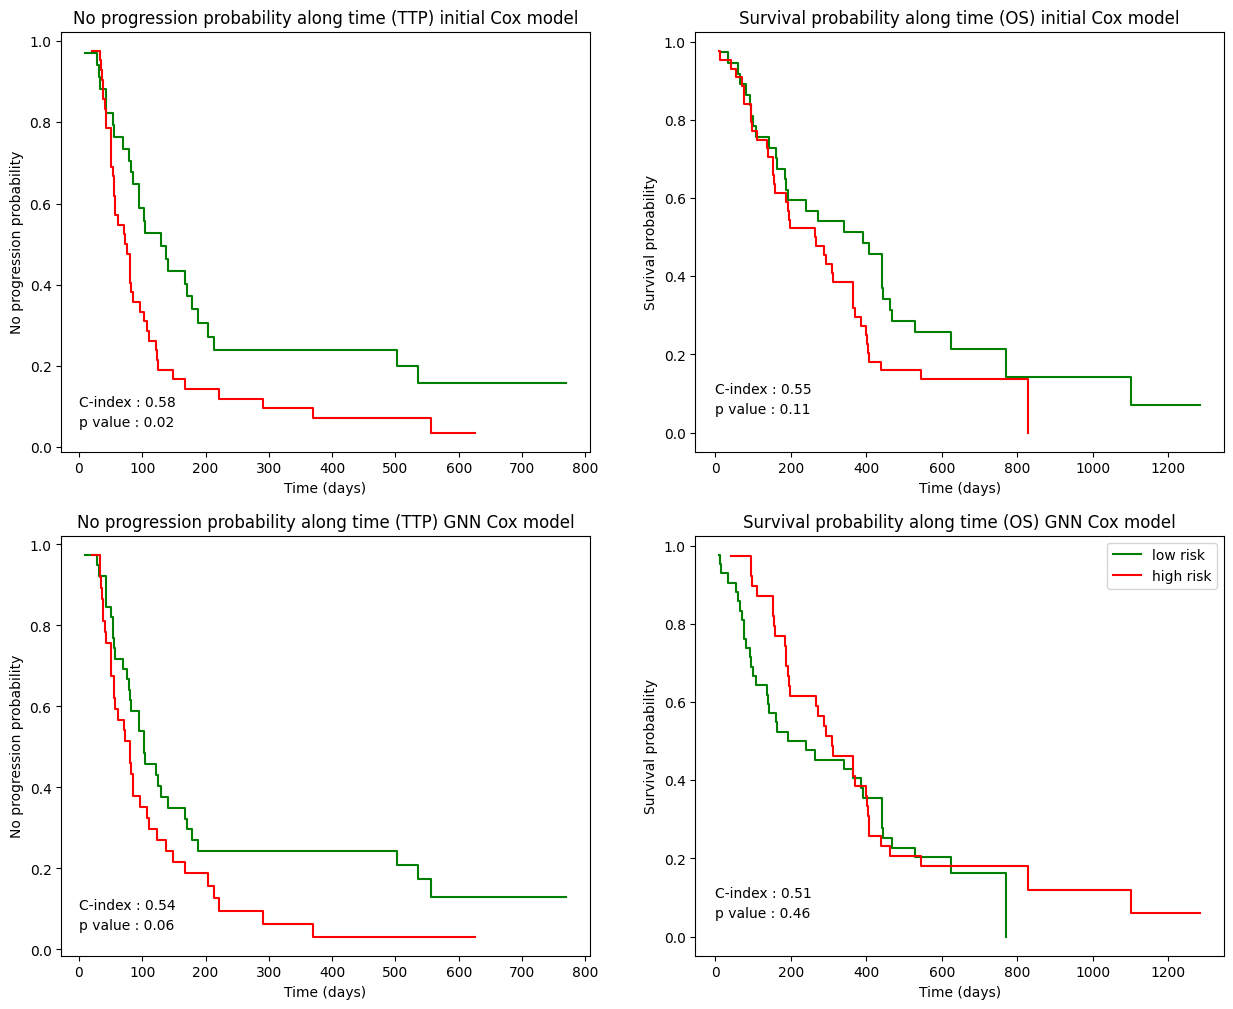

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15,12))
ax[0,0].step(time_axis_low_init_ttp, prob_axis_low_init_ttp, where='post',color='green',label='low risk')
ax[0,0].step(time_axis_high_init_ttp, prob_axis_high_init_ttp, where='post',color='red',label='high risk')
ax[0,0].set_xlabel('Time (days)')
ax[0,0].set_ylabel('No progression probability')
ax[0,0].set_title('No progression probability along time (TTP) initial Cox model')
ax[0,0].text(0,0.1,f'C-index : {c_index_init_ttp}')
ax[0,0].text(0,0.05,f'p value : {p_value_init_ttp}')

ax[0,1].step(time_axis_low_init_os, prob_axis_low_init_os, where='post',color='green',label='low risk')
ax[0,1].step(time_axis_high_init_os, prob_axis_high_init_os, where='post',color='red',label='high risk')
ax[0,1].set_xlabel('Time (days)')
ax[0,1].set_ylabel('Survival probability')
ax[0,1].set_title('Survival probability along time (OS) initial Cox model')
ax[0,1].text(0,0.1,f'C-index : {c_index_init_os}')
ax[0,1].text(0,0.05,f'p value : {p_value_init_os}')

ax[1,0].step(time_axis_low_gnn_ttp, prob_axis_low_gnn_ttp, where='post',color='green',label='low risk')
ax[1,0].step(time_axis_high_gnn_ttp, prob_axis_high_gnn_ttp, where='post',color='red',label='high risk')
ax[1,0].set_xlabel('Time (days)')
ax[1,0].set_ylabel('No progression probability')
ax[1,0].set_title('No progression probability along time (TTP) GNN Cox model')
ax[1,0].text(0,0.1,f'C-index : {c_index_gnn_ttp}')
ax[1,0].text(0,0.05,f'p value : {p_value_gnn_ttp}')

ax[1,1].step(time_axis_low_gnn_os, prob_axis_low_gnn_os, where='post',color='green',label='low risk')
ax[1,1].step(time_axis_high_gnn_os, prob_axis_high_gnn_os, where='post',color='red',label='high risk')
ax[1,1].set_xlabel('Time (days)')
ax[1,1].set_ylabel('Survival probability')
ax[1,1].set_title('Survival probability along time (OS) GNN Cox model')
ax[1,1].text(0,0.1,f'C-index : {c_index_gnn_os}')
ax[1,1].text(0,0.05,f'p value : {p_value_gnn_os}')

plt.legend()
plt.savefig('compare-init-gnn-cox-model-survival-curves.png')